### 네트워크 생성

각 꿀벌 군집을 노드로 두고,
공통 nearby 밀원 종을 공유한 경우 엣지로 연결하는 네트워크

In [2]:
import pandas as pd
import networkx as nx
from tqdm import tqdm

In [20]:
df_cerana = pd.read_csv("../../data/final/6_Apis_cerana_with_nearby.csv")
df_mellifera = pd.read_csv("../../data/final/6_Apis_mellifera_with_nearby.csv")

#### 1. nearby_* 열에서 연결 ID 리스트 추출

In [21]:
def extract_nearby_id_sets(df):
    df = df.copy()
    id_sets = []
    for _, row in df.iterrows():
        ids = {int(row[col]) for col in row.index if col.startswith("nearby_") and pd.notna(row[col])}
        id_sets.append(ids)
    df["nearby_ids"] = id_sets
    return df

#### 2. ID 공유를 기반으로 네트워크 구성

In [22]:
def build_id_network(df):
    G = nx.Graph()
    id_to_index = {row['ID']: idx for idx, row in df.iterrows()}  # ID → index mapping

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Building network"):
        this_id = row["ID"]
        G.add_node(this_id)

        for nid in row["nearby_ids"]:
            if nid in id_to_index:
                G.add_edge(this_id, nid)
    return G

#### 3. 중심성 계산

In [24]:
def compute_centrality(G):
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G)
    return degree, betweenness

#### 4. 전체 파이프라인

In [25]:
def run_id_based_network_pipeline(df, label="cerana"):
    print(f"\n [1] Processing {label} data")
    df = extract_nearby_id_sets(df)

    print(f" [2] Building ID-based network for {label}")
    G = build_id_network(df)

    print(f" [3] Computing centralities for {label}")
    deg, btw = compute_centrality(G)

    df["degree_centrality"] = df["ID"].map(deg)
    df["betweenness_centrality"] = df["ID"].map(btw)

    print(f"[DONE] {label} network: {len(G.nodes)} nodes, {len(G.edges)} edges")
    return df, G

In [26]:
df_cerana_result, G_cerana = run_id_based_network_pipeline(df_cerana, label="cerana")
df_mellifera_result, G_mellifera = run_id_based_network_pipeline(df_mellifera, label="mellifera")


 [1] Processing cerana data
 [2] Building ID-based network for cerana


Building network: 100%|██████████| 1159/1159 [00:00<00:00, 48708.43it/s]

 [3] Computing centralities for cerana


[DONE] cerana network: 349 nodes, 414 edges

 [1] Processing mellifera data
 [2] Building ID-based network for mellifera


Building network: 100%|██████████| 160/160 [00:00<00:00, 39436.37it/s]

 [3] Computing centralities for mellifera
[DONE] mellifera network: 117 nodes, 78 edges


### 중심성과 감염도 상관 분석

**중심성 지표(degree, betweenness)**와 감염 개체 수(발생두수) 간의 상관관계를 분석

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import matplotlib.font_manager as fm
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

In [28]:
def run_centrality_correlation_analysis(df, label="cerana", save_path=None):
    print(f"\n [{label}] 중심성과 감염 개체 수의 상관 분석")

    df_clean = df.dropna(subset=["발생두수", "degree_centrality", "betweenness_centrality"])

    # Pearson 상관계수
    p_deg, pval_deg = pearsonr(df_clean["발생두수"], df_clean["degree_centrality"])
    p_btw, pval_btw = pearsonr(df_clean["발생두수"], df_clean["betweenness_centrality"])

    # Spearman 상관계수
    s_deg, spval_deg = spearmanr(df_clean["발생두수"], df_clean["degree_centrality"])
    s_btw, spval_btw = spearmanr(df_clean["발생두수"], df_clean["betweenness_centrality"])

    print(f"[Pearson] 발생두수 vs Degree: r = {p_deg:.4f}, p = {pval_deg:.4f}")
    print(f"[Pearson] 발생두수 vs Betweenness: r = {p_btw:.4f}, p = {pval_btw:.4f}")
    print(f"[Spearman] 발생두수 vs Degree: ρ = {s_deg:.4f}, p = {spval_deg:.4f}")
    print(f"[Spearman] 발생두수 vs Betweenness: ρ = {s_btw:.4f}, p = {spval_btw:.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.regplot(data=df_clean, x="degree_centrality", y="발생두수", ax=axes[0])
    axes[0].set_title(f"{label} - Degree 중심성과 발생두수")

    sns.regplot(data=df_clean, x="betweenness_centrality", y="발생두수", ax=axes[1])
    axes[1].set_title(f"{label} - Betweenness 중심성과 발생두수")

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


 [cerana] 중심성과 감염 개체 수의 상관 분석
[Pearson] 발생두수 vs Degree: r = -0.1115, p = 0.0001
[Pearson] 발생두수 vs Betweenness: r = -0.0325, p = 0.2690
[Spearman] 발생두수 vs Degree: ρ = -0.0685, p = 0.0198
[Spearman] 발생두수 vs Betweenness: ρ = -0.0011, p = 0.9693


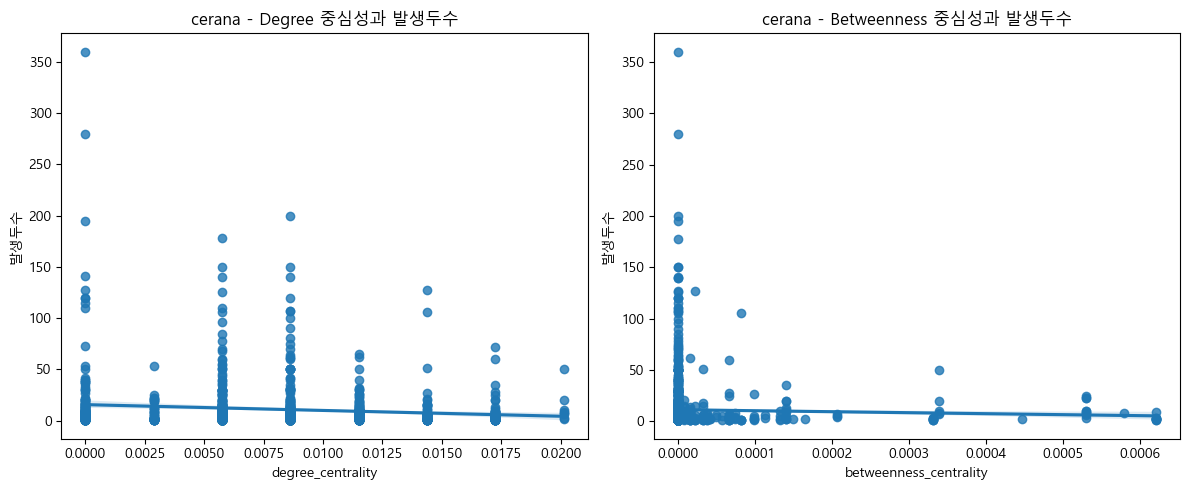


 [mellifera] 중심성과 감염 개체 수의 상관 분석
[Pearson] 발생두수 vs Degree: r = -0.0766, p = 0.3356
[Pearson] 발생두수 vs Betweenness: r = 0.0019, p = 0.9812
[Spearman] 발생두수 vs Degree: ρ = 0.0291, p = 0.7148
[Spearman] 발생두수 vs Betweenness: ρ = 0.0945, p = 0.2344


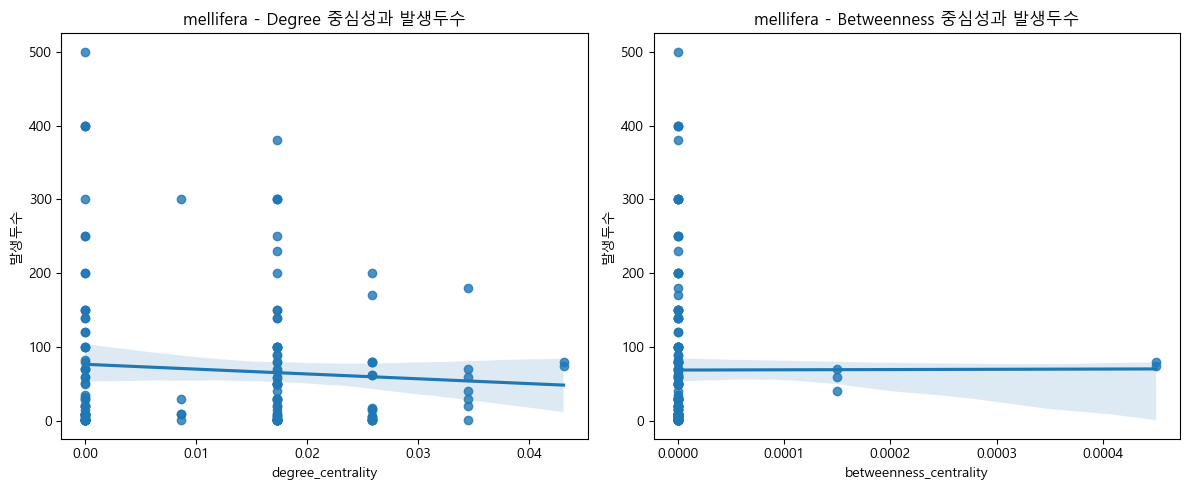

In [29]:
run_centrality_correlation_analysis(df_cerana_result, label="cerana", save_path="../../outputs/figures/S_3_1_cerana_centrality_correlation.png")
run_centrality_correlation_analysis(df_mellifera_result, label="mellifera", save_path="../../outputs/figures/S_3_2_mellifera_centrality_correlation.png")